# **Coin price predictions** (For my crypto investment on Binance)

Coin price over time is a time series. Therefore, predicting coin prices is a time series forecasting problem.
The step-by-step approach is as follows:

### *Data collection*

Some sources of crypto data includes:
- Yahoo Finance
- Binance API (focus on this as I bought some coins from this platform)

Generally, the following features of the coin price are relevant:
- OHLC
- Volume
- Market cap
- Technical indicators (Moving averages, relative strength index (RSI))

### *Data preprocessing*

- Handling missing values
- Normalize or scaling
- Lag features
- Train-test split

### *ML model to use in the current work*
- (S)ARIMA -> statsmodels
  #### In other notebooks:
- Ensemble: Random forest, XGBoost (ML) -> sckit-learn
- Combined: ARIMA-SVR (SVR: support vector regression)

### *Deploy the model using FastAPI*

Create a Fast API app for prediction





In [1]:
## import necessary libraries
# import yfinance 
import numpy as np
# for visualization
import matplotlib.pyplot as plt  
import plotly.graph_objects as go
import seaborn as sns
# for working with dataframe
import pandas as pd   
# for fetching data from API
import requests 
# for scaling and spliting preprocessing
from sklearn.preprocessing import MinMaxScaler   
from sklearn.model_selection import train_test_split
# following are for ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import root_mean_squared_error as rmse
# following are for Random forest and Gradient Boosting (XGBoost)
#from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb
# for FastAPI
from fastapi import FastAPI
import joblib

In [2]:
#======== Fetching data from source =========
def fetching_crypto_data(symbol="BTCUSDT", interval = '1d', limit=1000):
    '''
    Fetching Binance kline/candlestick data and transform json data to dataframe
    (Might loop to access more data)
    '''
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    response = requests.get(url)
    data = response.json()
    # convert json to dataframe 
    cols = ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time',\
           'Quote_asset_volume', 'Number_of_traders', 'Taker_buy_base_asset_volume',\
           'Taker_buy_quote_asset_volume', 'Ignore']
    df = pd.DataFrame(data, columns = cols)
    df['Open'] = df['Open'].astype(float)
    df['High'] = df['High'].astype(float)
    df['Low'] = df['Low'].astype(float)
    df['Close'] = df['Close'].astype(float)
    df['Volume'] = df['Volume'].astype(float)
    df['Date'] = pd.to_datetime(df['Open_time'], unit='ms')
    return df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]


#======== Adding two technical indicators Exponential Moving Average (EMA) and RSI
def add_technical_indicators(df, ema_period_short=[8,20], ema_period_long=[50,200], rsi_period=14): # these are typical params
    # EMA
    for p in ema_period_short:
        df[f'EMA_p={p}'] = df['Close'].ewm(span=p, adjust=False).mean()
    for p in ema_period_long:
        df[f'EMA_p={p}'] = df['Close'].ewm(span=p, adjust=False).mean()
 
    # RSI
    delta = df['Close'].diff()
    gain = np.where(delta>0, delta, 0)
    loss = np.where(delta<0, -delta, 0)

    avg_gain = pd.Series(gain).rolling(window=rsi_period).mean()
    avg_loss = pd.Series(loss).rolling(window=rsi_period).mean()

    rs = avg_gain/avg_loss
    df['RSI_close'] = 100 - (100/(1+rs))
    df.bfill(inplace=True)
    #df.fillna(method='bfill', inplace=True)

    return df

#======== Adding lag features (from 1,2,3 day to one week)
#def add_lag_features(df, lags = [1, 2, 3, 7]):
#    for lag in lags:
#        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
#        df[f'EMA_lag_{lag}'] = df['EMA_close'].shift(lag)
#        df[f'RSI_lag_{lag}'] = df['RSI_close'].shift(lag)
#    df.dropna(inplace=True)
#    return df

In [3]:
# Test a coin
df = fetching_crypto_data(symbol="BTCUSDT", interval = '1d', limit=1000)
df = add_technical_indicators(df)
#df = add_lag_features(df)

In [4]:
print(df.head())
print(df.info())
df.shape

        Date      Open      High       Low     Close        Volume  \
0 2022-12-22  16824.68  16868.52  16559.85  16821.43  176044.27235   
1 2022-12-23  16821.90  16955.14  16731.13  16778.50  161612.00947   
2 2022-12-24  16778.52  16869.99  16776.62  16836.12  100224.29096   
3 2022-12-25  16835.73  16857.96  16721.00  16832.11  125441.07202   
4 2022-12-26  16832.11  16944.52  16791.00  16919.39  124564.00656   

        EMA_p=8      EMA_p=20      EMA_p=50     EMA_p=200  RSI_close  
0  16821.430000  16821.430000  16821.430000  16821.430000  51.378788  
1  16811.890000  16817.341429  16819.746471  16821.002836  51.378788  
2  16817.274444  16819.129864  16820.388570  16821.153255  51.378788  
3  16820.571235  16820.366067  16820.848234  16821.262278  51.378788  
4  16842.530960  16829.796918  16824.712617  16822.238673  51.378788  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype         


(1000, 11)

### Now I am interested in the following coins (as I invested a (small) amount of my asset on them):
- FORM 
- SUI
- TRX
- LAYER
- ENA
- DOGE
- FET
- SYN
  
We now fetch them using Binance API, and rearrange them in the order the number of entries   

In [5]:
# list of coints
coin_symbols = ['FORMUSDT','SUIUSDT','TRXUSDT','LAYERUSDT',
                'ENAUSDT','DOGEUSDT', 'FETUSDT', 'SYNUSDT']
# Amount
coin_vol = [110.89136189, # FORM
           18.36022092,   # SUI
           200.69218228,  # TRX
           226.76276016,  # LAYER
           103.22103266,  # ENA
           250.00,        # DOGE  
           35.84428219,   # FET
           32.45382641,   # SYN
           ]
buy_date = [pd.to_datetime('2025-03-19'), ## FORM
           pd.to_datetime('2024-08-17'),  ## SUI
           pd.to_datetime('2025-08-06'),  ## TRX
           pd.to_datetime('2025-02-12'),  ## LAYER
           pd.to_datetime('2025-08-05'),  ## ENA
           pd.to_datetime('2024-08-13'),  ## DOGE
           pd.to_datetime('2024-08-12'),  ## FET
           pd.to_datetime('2024-08-17'),  ## SYN
           ]
ncoins = len(coin_symbols)
df_set = [0 for i in range(ncoins)]
interval = '1d'
limit = 1000
lags = [1, 2, 3, 7]
nentries = np.zeros(ncoins)
for i in range(ncoins):
    df_set[i] = fetching_crypto_data(symbol=coin_symbols[i], interval=interval, limit=limit)
    df_set[i] = add_technical_indicators(df_set[i])
    nentries[i] = df_set[i].shape[0]
# sort according to the number of entries in descending order
new_df_set = []
new_coin_list = []
new_coin_labels = []
new_coin_vol = []
new_buy_date = []
while nentries.size > 0:
    ind = np.argmax(nentries)
    new_df_set.append(df_set[ind].set_index('Date'))
    new_coin_list.append(coin_symbols[ind])
    new_coin_vol.append(coin_vol[ind])
    new_buy_date.append(buy_date[ind])
    #
    a = list(coin_symbols[ind])
    a.insert(len(a)-4, "/")
    new_coin_labels.append("".join(a))
    # 
    nentries = np.delete(nentries, ind)
    del df_set[ind]
    del coin_symbols[ind]
    del coin_vol[ind]
    del buy_date[ind]
print([new_df_set[i].shape for i in range(ncoins)])
print(new_coin_list)
print(new_coin_labels)

[(1000, 10), (1000, 10), (1000, 10), (938, 10), (868, 10), (533, 10), (218, 10), (182, 10)]
['TRXUSDT', 'DOGEUSDT', 'FETUSDT', 'SYNUSDT', 'SUIUSDT', 'ENAUSDT', 'LAYERUSDT', 'FORMUSDT']
['TRX/USDT', 'DOGE/USDT', 'FET/USDT', 'SYN/USDT', 'SUI/USDT', 'ENA/USDT', 'LAYER/USDT', 'FORM/USDT']


In [6]:
# asset alignment
n_features = new_df_set[0].shape[1]
df_set_cut = [new_df_set[i][new_df_set[i].index>new_buy_date[i]] for i in range(ncoins)]
coin_list_cut = new_coin_list.copy()
coin_vol_cut = new_coin_vol.copy()
buy_date_cut = new_buy_date.copy()
nentries_asset = np.array([df_set_cut[i].shape[0] for i in range(ncoins)])
print(nentries_asset)
df_asset = []
coin_list_asset = []
coin_labels_asset = []
coin_vol_asset = []
buy_date_asset = []
while nentries_asset.size > 0:
    ind = np.argmax(nentries_asset)
    df_asset.append(df_set_cut[ind])
    coin_list_asset.append(coin_list_cut[ind])
    coin_vol_asset.append(coin_vol_cut[ind])
    buy_date_asset.append(buy_date_cut[ind])
    #
    a = list(coin_list_cut[ind])
    a.insert(len(a)-4, "/")
    coin_labels_asset.append("".join(a))
    # 
    nentries_asset = np.delete(nentries_asset, ind)
    del df_set_cut[ind]
    del coin_list_cut[ind]
    del coin_vol_cut[ind]
    del buy_date_cut[ind]
df_asset_tot = pd.concat(df_asset,axis=1).fillna(0)
joint_columns = list(df_asset_tot.columns)
for i in range(n_features*ncoins):
   joint_columns[i] = joint_columns[i] + f'_{coin_list_asset[i//n_features]}'
df_asset_tot.columns = joint_columns
print(df_asset_tot.head())

[ 41 399 400 395 395  42 216 181]
            Open_FETUSDT  High_FETUSDT  Low_FETUSDT  Close_FETUSDT  \
Date                                                                 
2024-08-13         0.863         0.889        0.826          0.878   
2024-08-14         0.879         0.924        0.856          0.875   
2024-08-15         0.875         0.889        0.813          0.828   
2024-08-16         0.827         0.876        0.806          0.827   
2024-08-17         0.827         0.853        0.817          0.840   

            Volume_FETUSDT  EMA_p=8_FETUSDT  EMA_p=20_FETUSDT  \
Date                                                            
2024-08-13      29489444.1         0.882331          0.992643   
2024-08-14      38610840.6         0.880702          0.981439   
2024-08-15      38901030.2         0.868990          0.966826   
2024-08-16      34806832.5         0.859659          0.953509   
2024-08-17      16037535.3         0.855290          0.942699   

            EMA_p=5

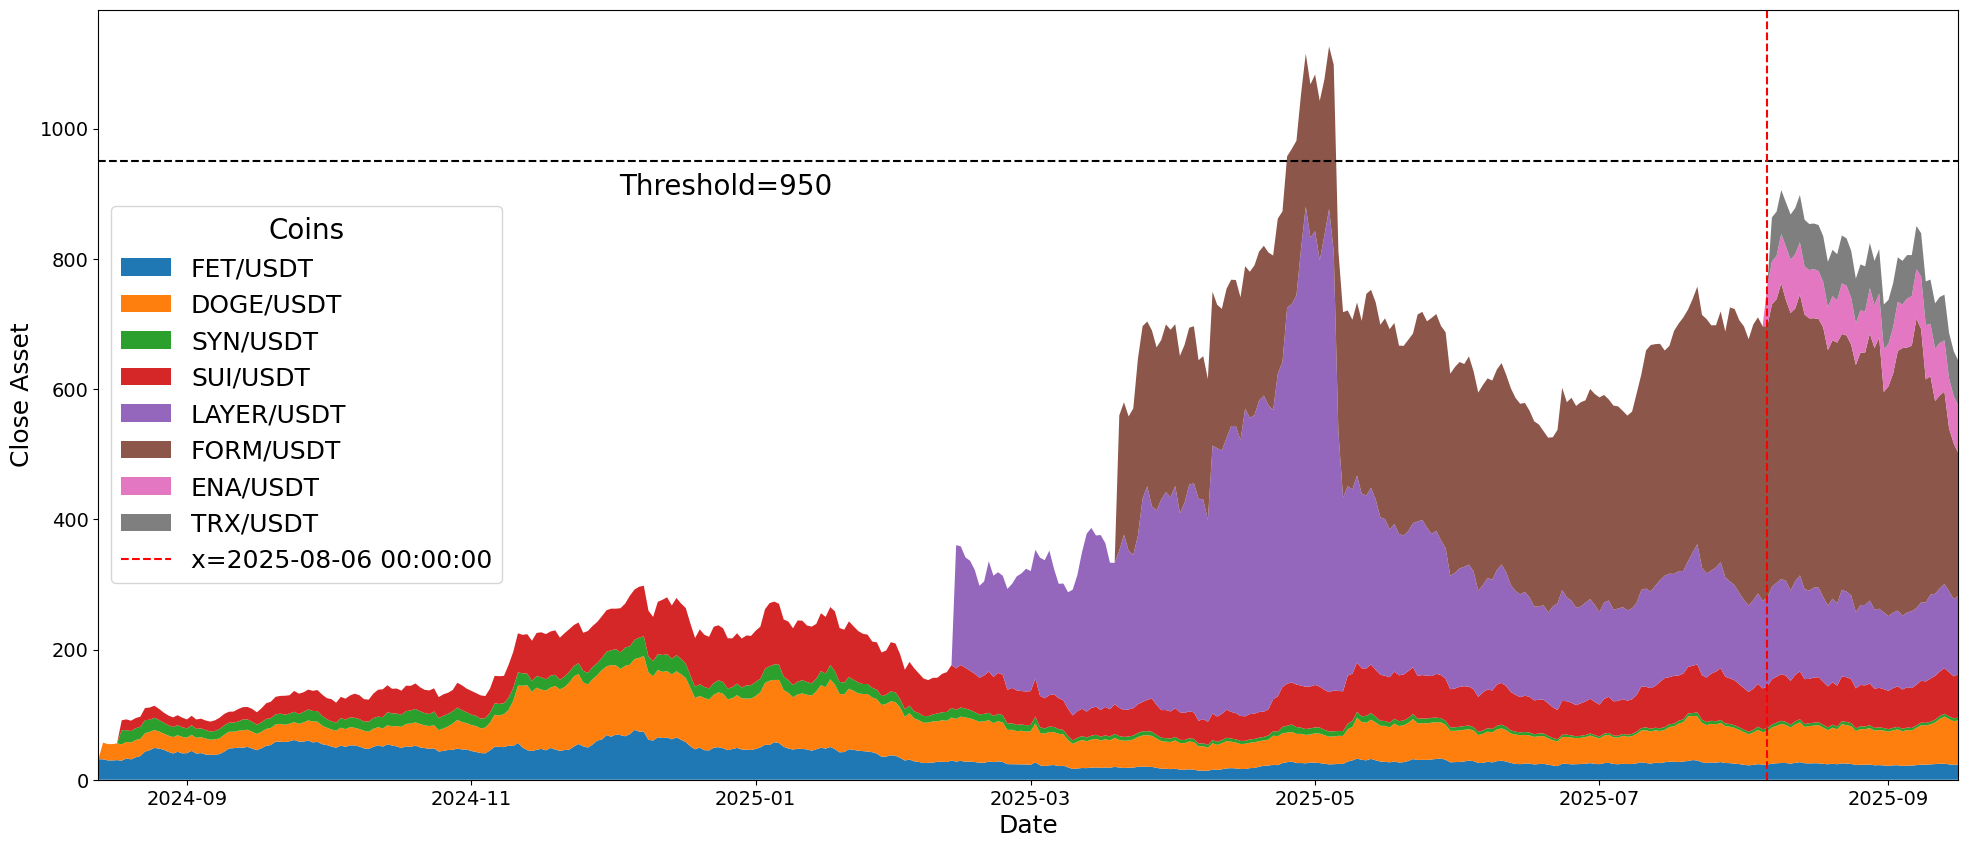

In [7]:

# Plotting close asset
fig_close, ax_close = plt.subplots(figsize=(24,10))
#
close_val = [df_asset_tot[f'Close_{coin_list_asset[i]}'].mul(coin_vol_asset[i]) for i in range(ncoins)]
#
thres = 950 # the threshold to sell (USDT)
ax_close.stackplot(df_asset_tot.index,close_val,labels=coin_labels_asset)
ax_close.axhline(y=thres,color='k',linestyle='--')
ax_close.axvline(x=max(new_buy_date), color='red', linestyle='--', label=f'x={max(new_buy_date)}')
ax_close.text(0.28,0.76,f"Threshold={thres}",transform=ax_close.transAxes,fontsize=20)
ax_close.legend(title='Coins',fontsize=18,title_fontsize=20)
ax_close.set_xlabel("Date",fontsize=18)
ax_close.set_ylabel("Close Asset",fontsize=18)
ax_close.set_xlim(df_asset_tot.index[0],df_asset_tot.index[len(df_asset_tot.index)-1])
ax_close.tick_params(axis='both', which='major', labelsize=14)
ax_close.tick_params(axis='both', which='minor', labelsize=12)


From the plot, one can see that the total asset (sum of Coin_price*coin_amount) has a clear growing tentency from the January 2024. There was sharp peak around in May 2025, which crossed the threshold and reached to the value ~1200 USDT (dominant by LAYER). The total asset varied around 700 USDT recently, and seems to have a downtrend in a short period. LAYER and FORM at this time (September 14th) takes more than 50% of the total asset. 

Let us now consider each coin price separately!

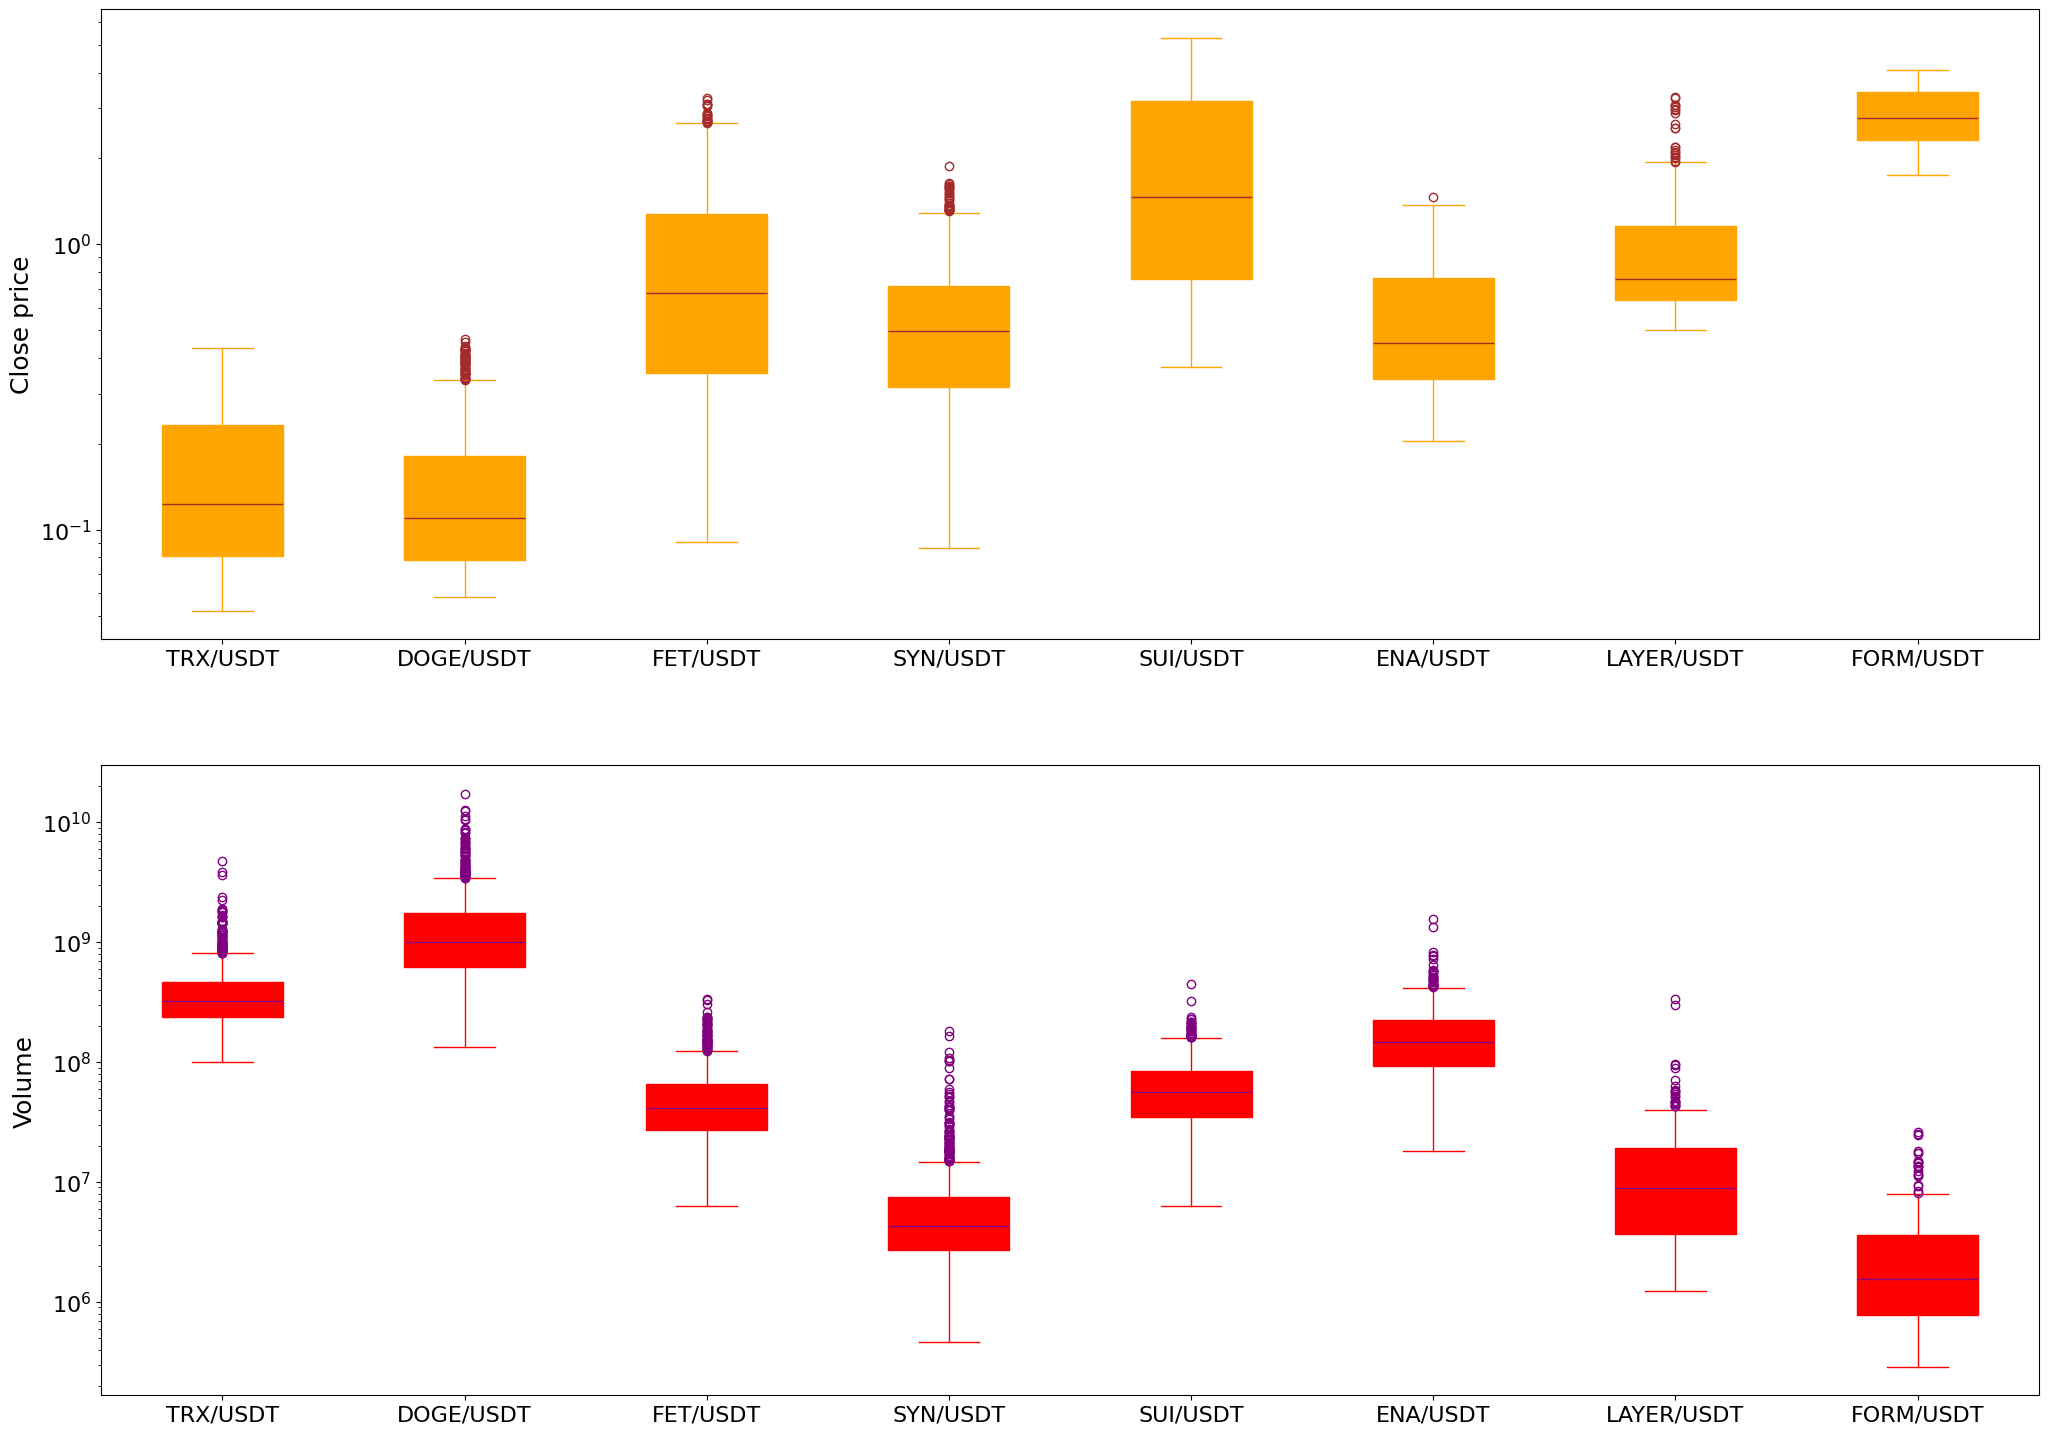

In [8]:
# Box plots
df_close_box = []
df_volume_box = []
labels_close = []
labels_volume = []
for i in range(ncoins):
    df_close_box.append(new_df_set[i]["Close"].tolist())
    df_volume_box.append(new_df_set[i]["Volume"].tolist())
    labels_close.append(f"{new_coin_labels[i]}")
    labels_volume.append(f"{new_coin_labels[i]}")

fig_box, ax_box = plt.subplots(2,1,figsize=(25,18))
ax_box[0].boxplot(df_close_box,tick_labels=labels_close, \
                 patch_artist=True,
                boxprops=dict(facecolor='orange', color='orange'),
                capprops=dict(color='orange'),
                whiskerprops=dict(color='orange'),
                flierprops=dict(color='brown', markeredgecolor='brown'),
                medianprops=dict(color='brown'))
ax_box[1].boxplot(df_volume_box,tick_labels=labels_volume, \
                 patch_artist=True,
                boxprops=dict(facecolor='red', color='red'),
                capprops=dict(color='red'),
                whiskerprops=dict(color='red'),
                flierprops=dict(color='purple', markeredgecolor='purple'),
                medianprops=dict(color='purple'))
ax_box[1].set_yscale('log')
ax_box[0].set_yscale('log')
ax_box[0].set_ylabel('Close price',fontsize=18)
ax_box[1].set_ylabel('Volume',fontsize=18)
for i in range(2):
    ax_box[i].tick_params(axis='both', which='major', labelsize=16)
    ax_box[i].tick_params(axis='both', which='minor', labelsize=14)

In [9]:
# RSI thresholds
rsi_upper = [70*np.ones(len(new_df_set[i].index)) for i in range(ncoins)]
rsi_lower = [30*np.ones(len(new_df_set[i].index)) for i in range(ncoins)]
#
colors = plt.cm.jet(np.linspace(0,1,ncoins))

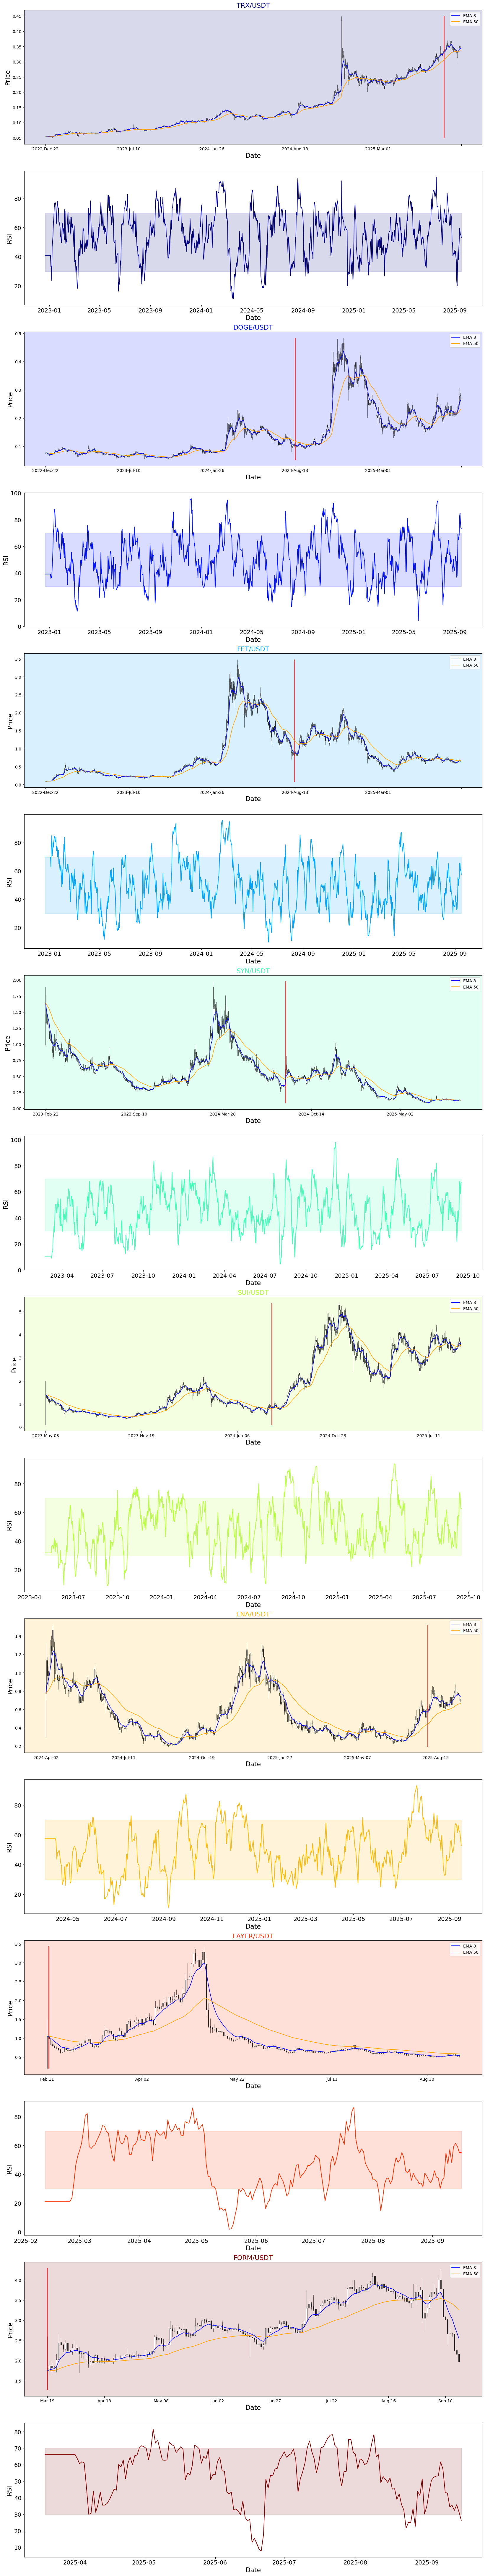

In [10]:
# plot OHLC and SMA
import mplfinance as mpf
fig_candle, ax_candle = plt.subplots(2*ncoins,1,figsize=(20,14*ncoins))
for i in range(ncoins):
    apds = [
        mpf.make_addplot(new_df_set[i]['EMA_p=8'],  color='blue', label='EMA 8',ax=ax_candle[2*i]),
        mpf.make_addplot(new_df_set[i]['EMA_p=50'], color='orange', label='EMA 50',ax=ax_candle[2*i])
    ]
    mpf.plot(new_df_set[i], type='candle', addplot=apds,  volume=False, ax=ax_candle[2*i], \
             vlines=dict(vlines=[new_buy_date[i]], linewidths=2, alpha=0.7, colors='red'),\
             axtitle=new_coin_labels[i], xrotation=0,warn_too_much_data=100000)
    ax_candle[2*i+1].plot(new_df_set[i].index,new_df_set[i]["RSI_close"],color=colors[i])
    ax_candle[2*i+1].fill_between(new_df_set[i].index,rsi_lower[i],rsi_upper[i],alpha=0.15,color=colors[i])
    ax_candle[2*i].patch.set_facecolor(colors[i])
    ax_candle[2*i].patch.set_alpha(0.15)
    ax_candle[2*i+1].set_xlabel("Date",fontsize=16)
    ax_candle[2*i].set_xlabel("Date",fontsize=16)
    ax_candle[2*i].set_ylabel("Price",fontsize=16)
    ax_candle[2*i].set_title(new_coin_labels[i],fontsize=16,color=colors[i])
    ax_candle[2*i+1].set_ylabel("RSI",fontsize=16)
    ax_candle[2*i+1].tick_params(axis='both', which='major', labelsize=14)
    ax_candle[2*i+1].tick_params(axis='both', which='minor', labelsize=12)


### General comments on box plots:


### Let's us analyse the current trend of TRX, for example

- There is a clear uptrend in general when looking at the long-term variation. The coin price increases by a factor of ~6 times from Dec-2022 up to present (September 2025) -> seems to be a good coin for long-term investment.
- In recent days, the short EMA crosses above the long EMA (aka "Golden Crossover"), indicating an uptrend in the near future.
- Recent prices are about EMAs -> bullish trend (short-term trend is stronger than long term)


## Build ARIMA models

### 1. Stationary Test with ADF

In [11]:
for i in range(ncoins):
    result = adfuller(new_df_set[i]['Close'])
    print(f"Coin {new_coin_labels[i]}:")
    print(f"\t p-value = {result[1]}")
    if result[1] > 0.05:
        print(f"\t -> not stationary!")
    else:
        print(f"\t -> stationary!")
    print("\n")


Coin TRX/USDT:
	 p-value = 0.984255316269876
	 -> not stationary!


Coin DOGE/USDT:
	 p-value = 0.36804670122355854
	 -> not stationary!


Coin FET/USDT:
	 p-value = 0.23672667888689747
	 -> not stationary!


Coin SYN/USDT:
	 p-value = 0.06956763052438374
	 -> not stationary!


Coin SUI/USDT:
	 p-value = 0.7648536263799876
	 -> not stationary!


Coin ENA/USDT:
	 p-value = 0.21423453408180737
	 -> not stationary!


Coin LAYER/USDT:
	 p-value = 0.43621207499007264
	 -> not stationary!


Coin FORM/USDT:
	 p-value = 0.6211755527595744
	 -> not stationary!




So the time-evolved prices of all the coins are not stationary. For the PACF and ACF analysis, one needs to take the difference(s) to obtained the stationary dadaset 

In [12]:
## 1st Differencing 
df_diff = [0 for i in range(ncoins)]
for i in range(ncoins):
    df_diff[i] = new_df_set[i]['Close'].diff(1).dropna()
    result = adfuller(df_diff[i])
    print(f"Coin {new_coin_labels[i]}:")
    print(f"\tp-value (1D) = {result[1]}")
    if result[1] > 0.05:
        print(f"\t -> not stationary!")
    else:
        print(f"\t -> stationary!")
    print("\n")
#print(tmp_df)

Coin TRX/USDT:
	p-value (1D) = 2.103760747521559e-28
	 -> stationary!


Coin DOGE/USDT:
	p-value (1D) = 1.342603434714386e-08
	 -> stationary!


Coin FET/USDT:
	p-value (1D) = 9.239535935877068e-08
	 -> stationary!


Coin SYN/USDT:
	p-value (1D) = 4.915349604814289e-16
	 -> stationary!


Coin SUI/USDT:
	p-value (1D) = 3.5765583348883676e-23
	 -> stationary!


Coin ENA/USDT:
	p-value (1D) = 0.0
	 -> stationary!


Coin LAYER/USDT:
	p-value (1D) = 6.039181111760288e-07
	 -> stationary!


Coin FORM/USDT:
	p-value (1D) = 0.13393277708691614
	 -> not stationary!




All, but except for FORM, coins are now stationary. We process the second-order difference for FORM!

In [13]:
tmp = df_diff[ncoins-1].diff().dropna() # extract FORM coin 1st difference and calculate the second difference
result = adfuller(tmp)
print(f"\tp-value = {result[1]}")
if result[1] > 0.05:
    print(f"\t -> not stationary!")
else:
    df_diff[ncoins-1] = tmp
    print(f"\t -> stationary!")

	p-value = 1.2238081698533034e-11
	 -> stationary!


### 2. ACF and PACF plots

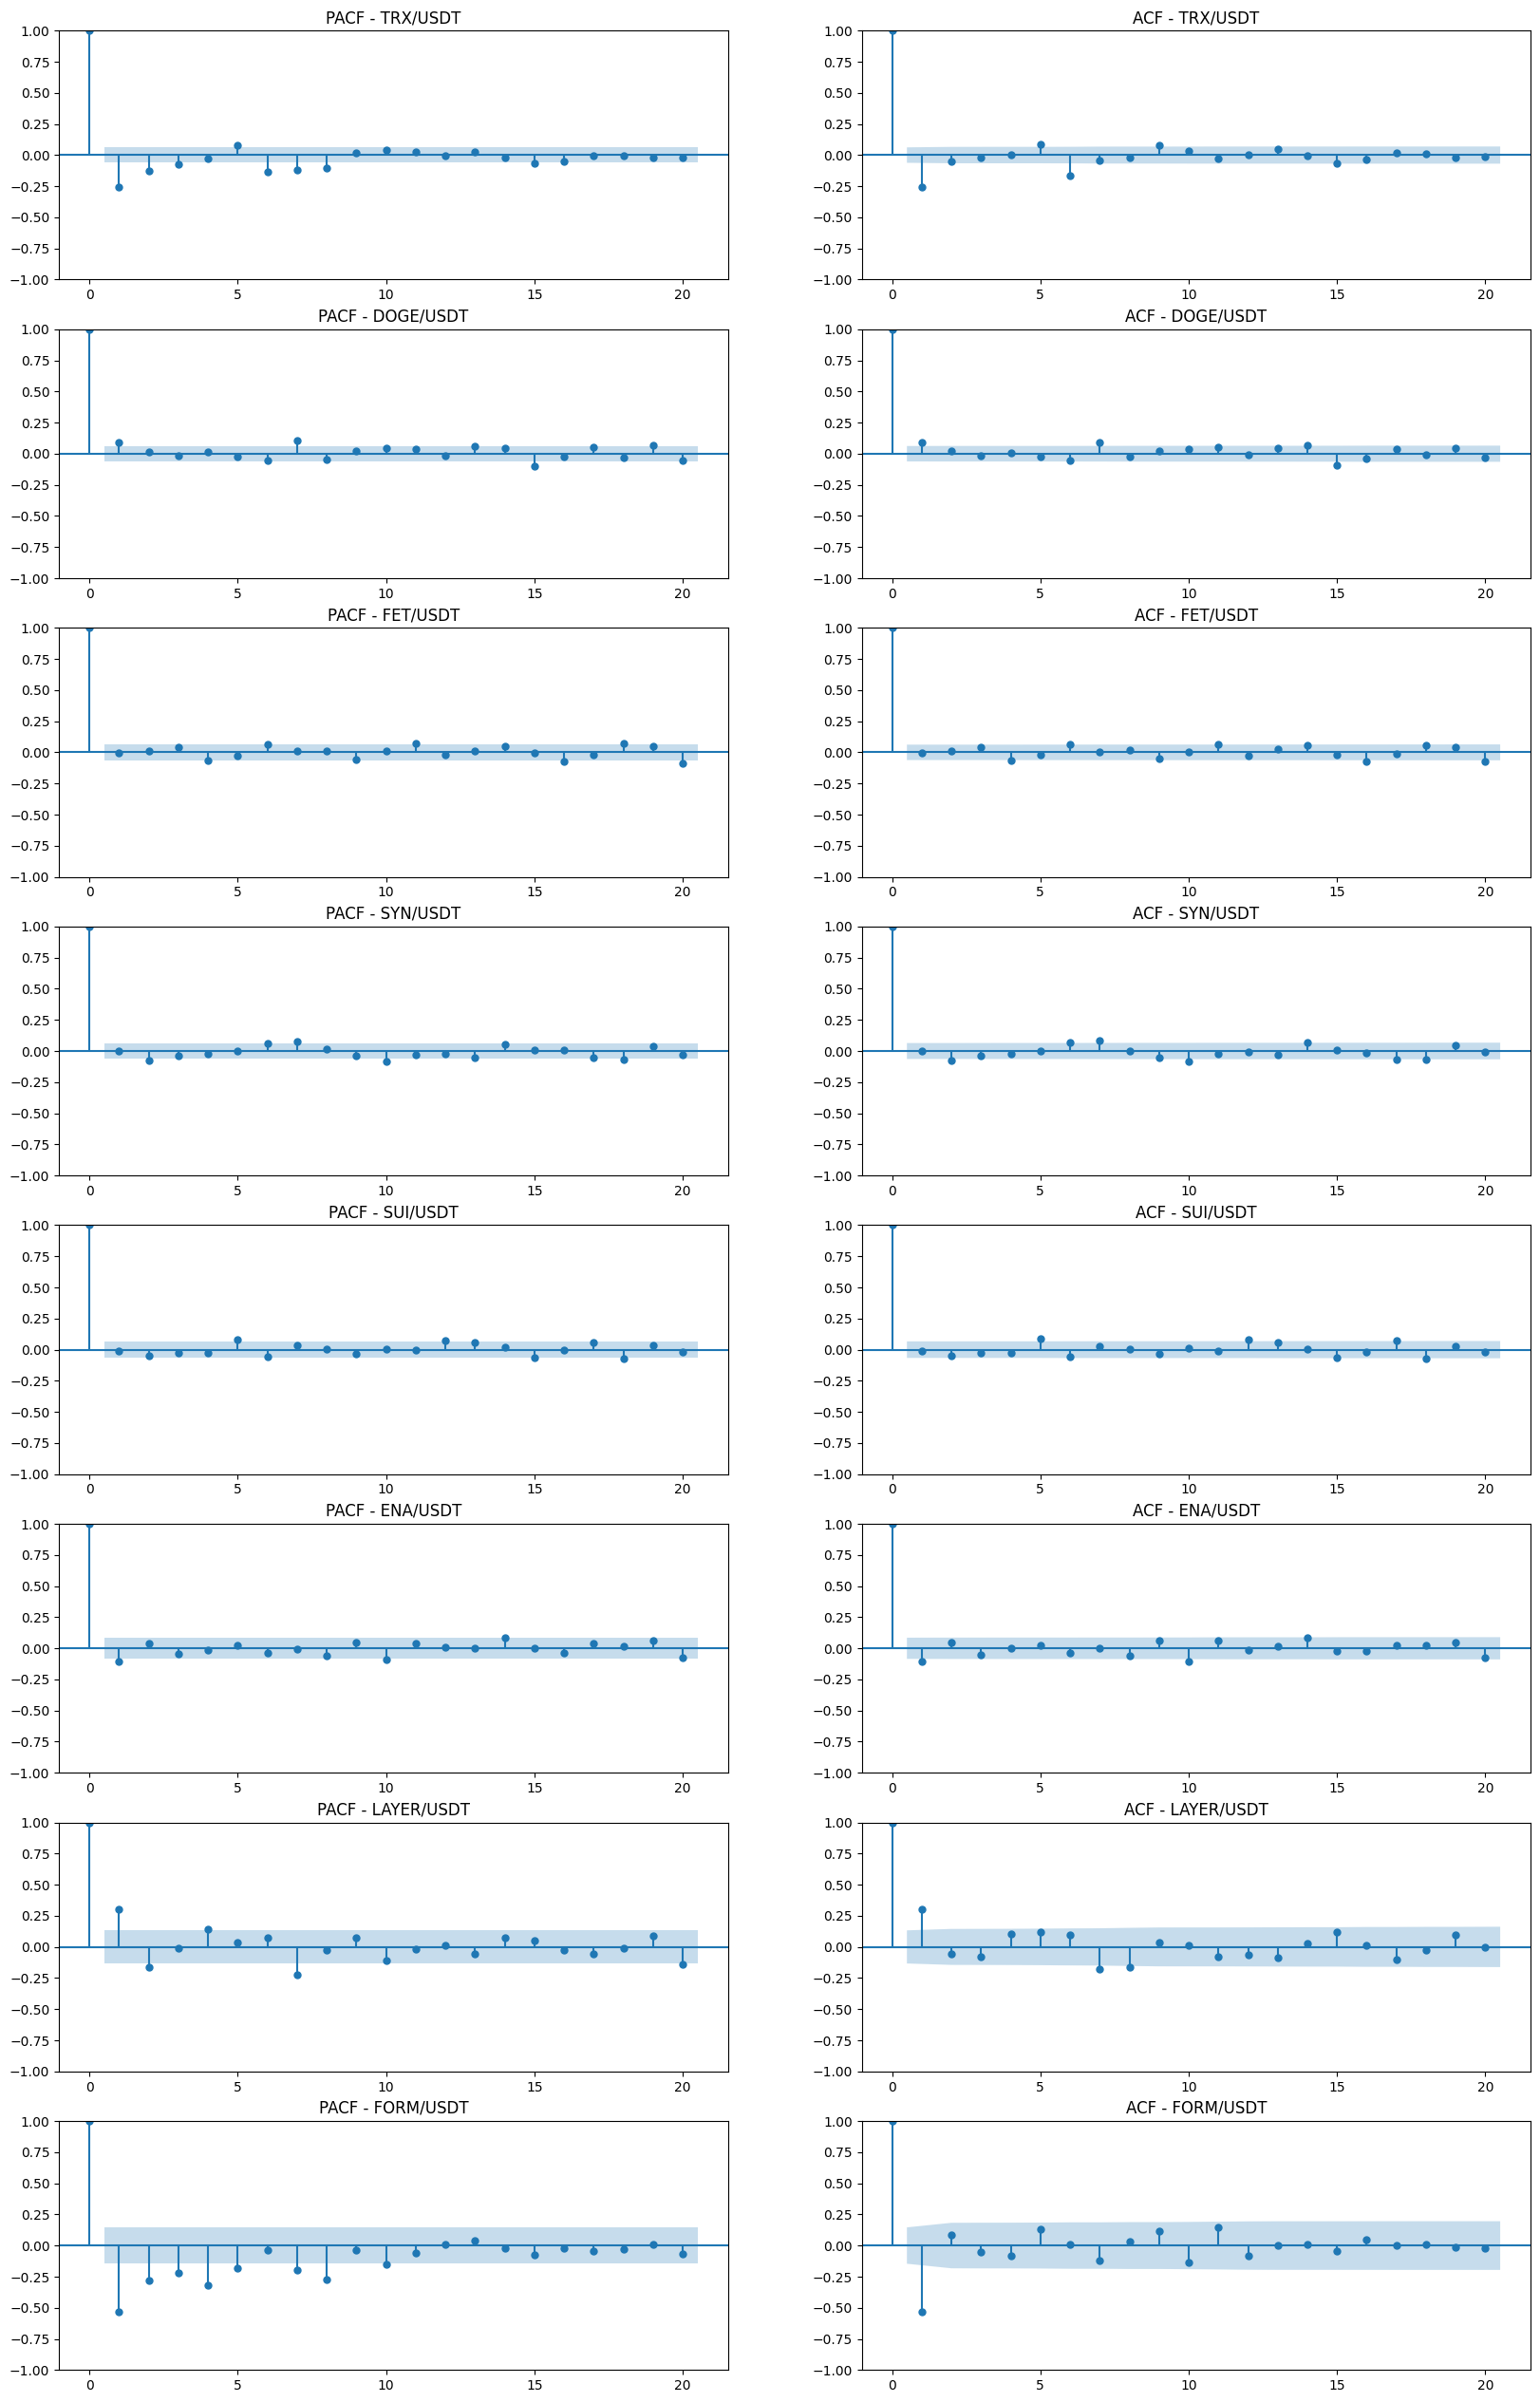

In [14]:
# ACF and PACF for (p,q) estimation
lags = range(21)
alpha = 0.05 # significant level
coin_acf = [None for i in range(ncoins)]
coin_pacf = [None for i in range(ncoins)]
ci_acf = [None for i in range(ncoins)]
ci_pacf = [None for i in range(ncoins)]
for i in range(ncoins):
    coin_acf[i], ci_acf[i] = acf(df_diff[i], nlags=20, alpha=alpha, qstat=False)
    coin_pacf[i], ci_pacf[i] = pacf(df_diff[i], nlags=20, alpha=alpha)

# calculate the exclusive band in 
conf_lower_acf = [(ci_acf[i][:,0] - coin_acf[i]) for i in range(ncoins)]
conf_upper_acf = [(ci_acf[i][:,1] - coin_acf[i]) for i in range(ncoins)]
conf_lower_pacf = [(ci_pacf[i][:,0] - coin_pacf[i]) for i in range(ncoins)]
conf_upper_pacf = [(ci_pacf[i][:,1] - coin_pacf[i]) for i in range(ncoins)]

# max spikes search
max_lag_acf = list(np.zeros(ncoins))
max_lag_pacf = list(np.zeros(ncoins))
for i in range(ncoins):
    for j in lags:
        if (coin_acf[i][j] >= conf_lower_acf[i][j]) and (coin_acf[i][j] <= conf_upper_acf[i][j]):
            max_lag_acf[i] = j
            break
    for j in lags:
        if (coin_pacf[i][j] >= conf_lower_pacf[i][j]) and (coin_pacf[i][j] <= conf_upper_pacf[i][j]):
            max_lag_pacf[i] = j
            break

fig_corr, ax_corr = plt.subplots(ncoins,2,figsize=(20,4*ncoins))
for i in range(ncoins):
    plot_pacf(df_diff[i],lags=20,ax=ax_corr[i,0],title=f'PACF - {new_coin_labels[i]}')
    plot_acf(df_diff[i],lags=20,ax=ax_corr[i,1],title=f'ACF - {new_coin_labels[i]}',bartlett_confint=True)

In [15]:
print(max_lag_acf)
print(max_lag_pacf)


[2, 2, 1, 1, 1, 2, 2, 2]
[4, 2, 1, 1, 1, 2, 3, 6]


### 3. ARIMA model with grid search 
In general, it is hard to determine true AR(p) and MA(q) from the previous plots. Instead, we will use the grid search, with:
- max_d = 2
- max_p = 5
- max_q = 5

In [16]:
import warnings
import itertools

warnings.filterwarnings('ignore')

pdq = list(itertools.product(range(7), range(3), range(7)))

best_aic = [np.inf for i in range(ncoins)]
best_order_aic = [None for i in range(ncoins)]
best_model_aic = [None for i in range(ncoins)]
best_rms = [np.inf for i in range(ncoins)]
best_order_rms = [None for i in range(ncoins)]
best_model_rms = [None for i in range(ncoins)]
# train, test split
train = [None for i in range(ncoins)]
test = [None for i in range(ncoins)]
for i in range(ncoins):
    train_size = int(len(new_df_set[i]['Close']) * 0.85)
    train[i], test[i] = new_df_set[i]['Close'].iloc[:train_size], new_df_set[i]['Close'].iloc[train_size:]
# Best model based on aic statistics 
for i in range(ncoins):
    print(new_coin_labels[i])
    for order in pdq:
        try:
            model = ARIMA(train[i], order=order,enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit()
            if results.aic < best_aic[i]:
                best_aic[i] = results.aic
                best_order_aic[i] = order
                best_model_aic[i] = results
        except:
            continue
print(best_aic)
print(best_order_aic)


TRX/USDT
DOGE/USDT
FET/USDT
SYN/USDT
SUI/USDT
ENA/USDT
LAYER/USDT
FORM/USDT
[-5643.335209014545, -5614.958018757505, -1947.7802616000936, -2504.909478149566, -1051.0689426342026, -1498.2613140986732, -244.0252271310834, -247.22383602890318]
[(2, 0, 1), (1, 1, 0), (3, 0, 2), (3, 0, 0), (3, 1, 4), (6, 1, 6), (0, 1, 1), (2, 1, 4)]


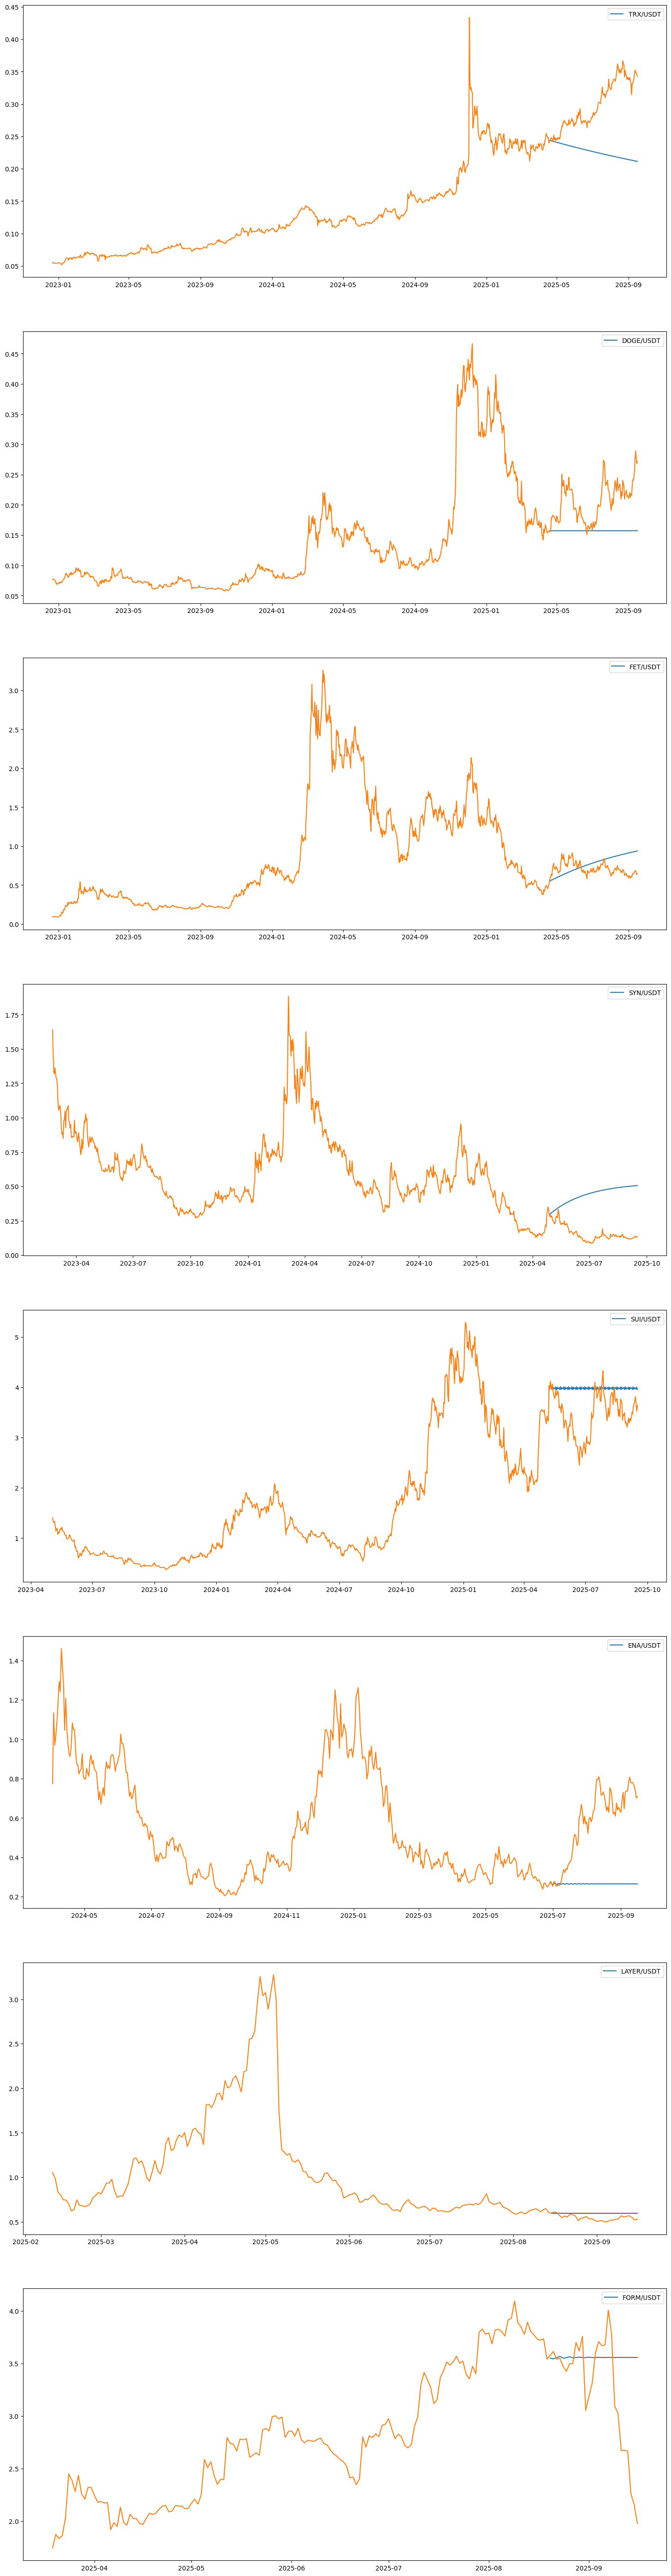

In [17]:
# plot
plt_pred, ax_pred = plt.subplots(ncoins,1,figsize = (18,ncoins*9))
for i in range(ncoins):
    forecast_aic = best_model_aic[i].forecast(steps=len(test[i]))
#print(forecast_aic)
    ax_pred[i].plot(forecast_aic.index,forecast_aic, label = new_coin_labels[i])
    ax_pred[i].plot(new_df_set[i].index,new_df_set[i]['Close'])
    ax_pred[i].legend()

The best-aic ARIMA models provides poor forecasts (just by visual comparison to the test sets). It suggests that something might be missing in the analysis. Indeed, the correlograms seemed to indicate that the data might exhibit certain seasonal component. Let's check!  

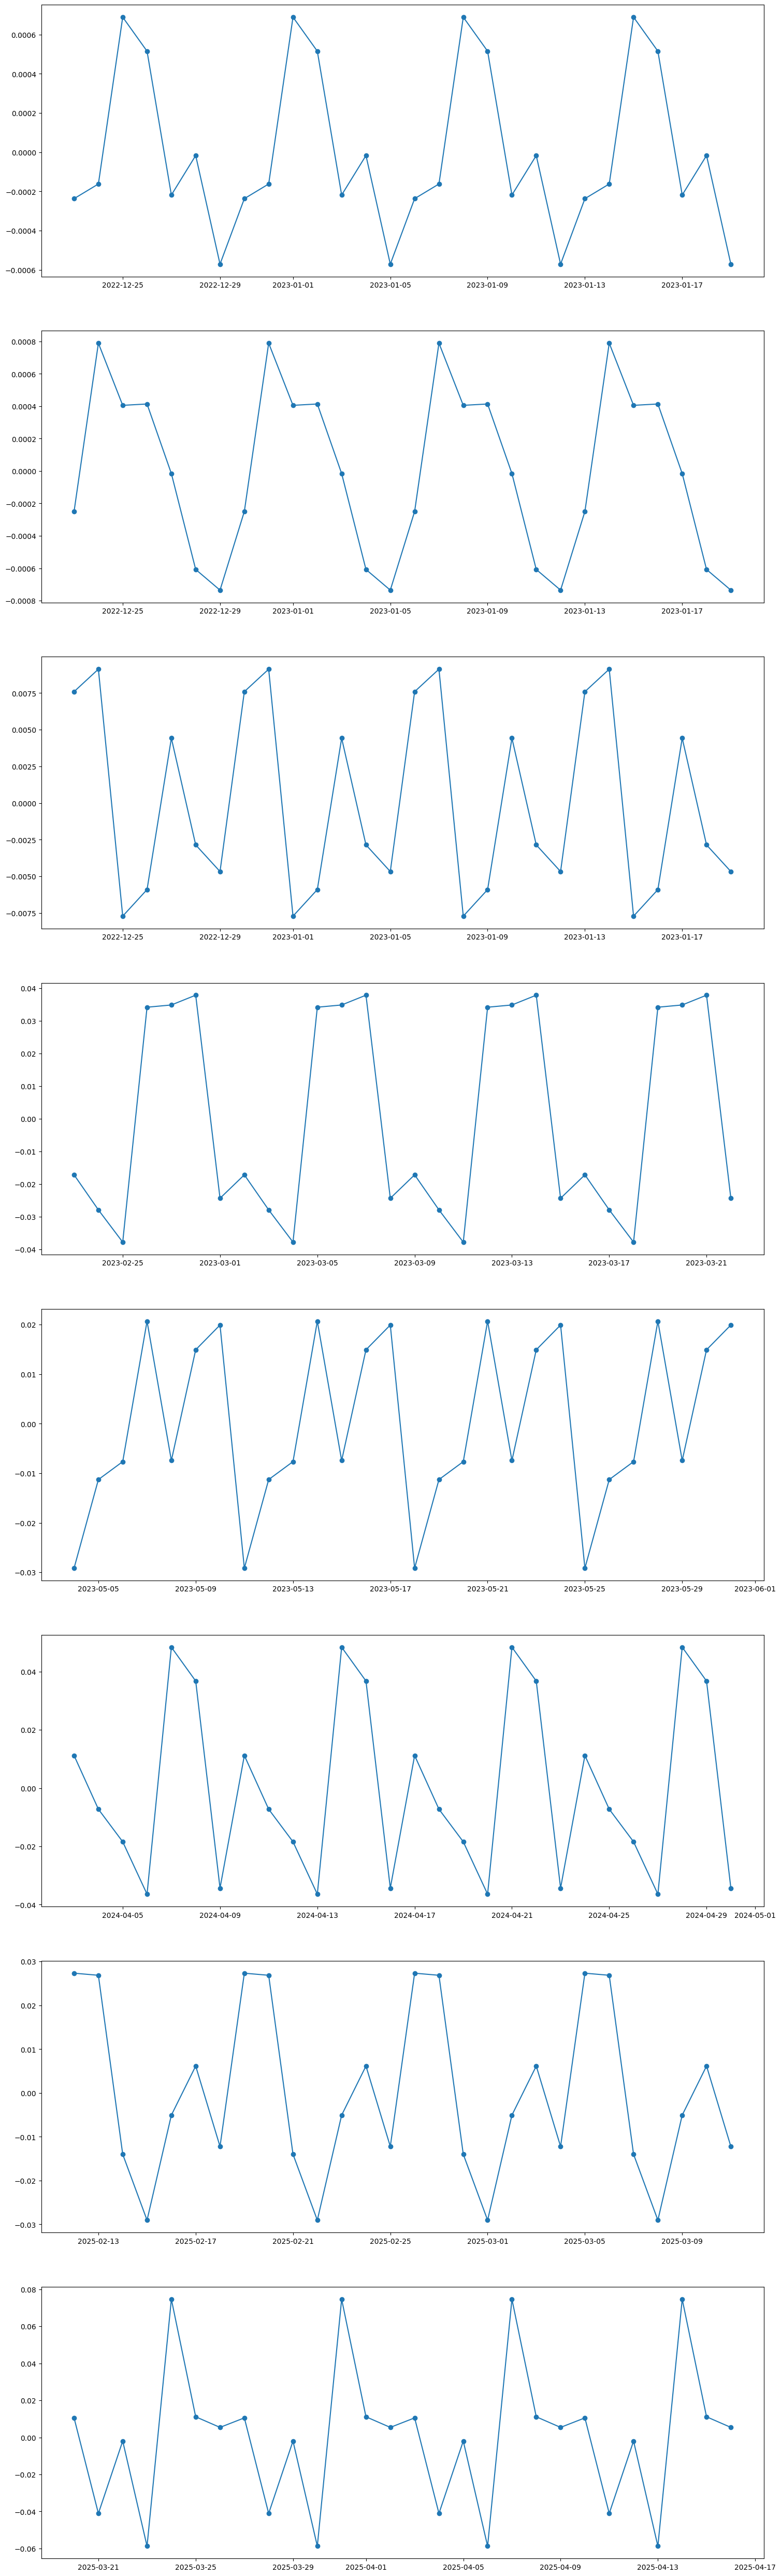

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig_s, ax_s = plt.subplots(ncoins,1,figsize = (18,8*ncoins))
for i in range(ncoins):
    result_add = seasonal_decompose(new_df_set[i]['Close'].iloc[1:29], model='additive')
    ax_s[i].plot(result_add.seasonal, '-o', label='Additive Trend')

# Check the weekday
#day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
#for i in range(ncoins):
#    print(day[new_df_set[i].index[1].weekday()])

Here I plot the first 28 data points. We can see that there is clearly a weekly seasonality for all coins. 
So, let's know apply the SARIMA models with grid search to find the best aic models! 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


pdq = list(itertools.product(range(3), range(3), range(3)))
PDQs = list(itertools.product(range(2), range(2), range(2), range(7,8)))

best_aic_sarima = [np.inf for i in range(ncoins)]
best_order_aic_sarima = [None for i in range(ncoins)]
best_sorder_aic_sarima = [None for i in range(ncoins)]
best_model_aic_sarima = [None for i in range(ncoins)]

# train, test split
train = [None for i in range(ncoins)]
test = [None for i in range(ncoins)]
for i in range(ncoins):
    train_size = int(len(new_df_set[i]['Close']) * 0.8)
    train[i], test[i] = new_df_set[i]['Close'].iloc[:train_size], new_df_set[i]['Close'].iloc[train_size:]
# Best model based on aic statistics 
for i in range(ncoins):
    print(new_coin_labels[i])
    for order in pdq:
        for order_seasonal in PDQs:
            try:
                model = SARIMAX(train[i], order=order, seasonal_order = order_seasonal,enforce_stationarity=False,
                            enforce_invertibility=False)
                results = model.fit()
                if results.aic < best_aic_sarima[i]:
                    best_aic_sarima[i] = results.aic
                    best_order_aic_sarima[i] = order
                    best_sorder_aic_sarima[i] = order_seasonal
                    best_model_aic_sarima[i] = results
            except:
                continue

TRX/USDT


In [ ]:
plt_spred, ax_spred = plt.subplots(ncoins,1,figsize = (18,ncoins*9))
for i in range(ncoins):
    forecast = best_model_aic_sarima[i].get_forecast(steps=50)
    forecast_mean = forecast.predicted_mean
    forecast_ci = forecast.conf_int()
    full_forecast = pd.concat([train[i], forecast_mean])
    #print(forecast_sarima.tail())
#print(forecast_aic)
    #index_of_fc = pd.date_range(test[0] + pd.DateOffset(days=1), periods=len(test[i]), freq='MS')
    #forecast_series = pd.Series(fitted, index=index_of_fc)
    ax_spred[i].plot(full_forecast, 'r', label = new_coin_labels[i])
    ax_spred[i].plot(new_df_set[i].index,new_df_set[i]['Close'],'b')
    ax_spred[i].fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='orange', alpha=0.3)
    ax_spred[i].legend()

In [ ]:
import pmdarima as pm

pred_ss[i] = [None for i in range(ncoins)]
pred_ns[i] = [None for i in range(ncoins)]
for i in range(ncoins):
    model_ss = pm.auto_arima(
        train[i],
        start_p=0, start_q=0,
        start_P=0, start_Q=0,
        seasonal=True,
        m=7,  # seasonality (12 months)
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    model_ss = pm.auto_arima(
        train[i],
        start_p=0, start_q=0,
        start_P=0, start_Q=0,
        seasonal=False,
        m=1,  # seasonality (12 months)
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    print(new_coin_labels[i])
    print(model.summary)
    pred[i] = pd.DataFrame(model.predict(n_periods=len(test[i])), index = test[i].index)


    
